### Import Packages

In [140]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from deap import base, creator, tools, algorithms
import warnings
warnings.filterwarnings('ignore')


### Read in Data

In [112]:
df = pd.read_csv("./tr_eikon_eod_data.csv", index_col = 0, parse_dates = True).dropna()
df.index = pd.to_datetime(df.index)

# 1a
df = df[['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N']]
aapl = pd.DataFrame({"Close": df['AAPL.O']})
msft = pd.DataFrame({"Close": df['MSFT.O']})
intc = pd.DataFrame({"Close": df['INTC.O']})
amzn = pd.DataFrame({"Close": df['AMZN.O']})
gs = pd.DataFrame({"Close": df['GS.N']})
tickers = [("aapl", aapl), ("msft", msft), ("intc", intc), ("amzn", amzn), ("gs", gs)]

In [151]:
def train_test_split(df, ratio = 0.5):
    n = len(df)
    split = math.floor(n * ratio)
    
    return df[:split], df[split:]
    
def calculate_macd(df, short_window, long_window, signal_window):
    # Calculate short-term and long-term exponential moving averages
    df['Short_EMA'] = df["Close"].ewm(span=short_window, min_periods=1).mean()
    df['Long_EMA'] = df["Close"].ewm(span=long_window, min_periods=1).mean()

    # Calculate MACD line
    df['MACD'] = df['Short_EMA'] - df['Long_EMA']
    
     # Calculate signal line (signal_window-day EMA of MACD line)
    df['Signal_Line'] = df['MACD'].ewm(span=signal_window, min_periods=1).mean()

    return df

def generate_signals(df):
    # Generate buy signals
    df['Buy_Signal'] = np.where(df['MACD'] > df['Signal_Line'], 1, 0)

    # Generate sell signals
    df['Sell_Signal'] = np.where(df['MACD'] < df['Signal_Line'], 1, 0)
    return df

def backtest_strategy(df):
    # Initialize variables
    position = 0
    entry_price = 0

    df["PnL"] = 0.0

    # Iterate through each row
    for index, row in df.iterrows():
        if row['Buy_Signal'] == 1 and position == 0:
            # Buy signal
            position = 1
            entry_price = row['Close']
        elif row['Sell_Signal'] == 1 and position == 1:
            # Sell signal
            position = 0
            exit_price = row['Close']
            df.loc[index, "PnL"] = exit_price - entry_price

    # Calculate cumulative P&L
    return df

# Define genetic algorithm functions
def evaluate_strategy(individual, df):
    short_window, long_window, signal_window = individual
    processed_data = calculate_macd(df.copy(), short_window, long_window, signal_window)
    signals_data = generate_signals(processed_data)
    pnl = backtest_strategy(signals_data)["PnL"]
    return pnl.cumsum().iloc[-1],  # Return final P&L as a tuple

def genetic_algorithm(df, population_n=50, include_genome=[]):
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)
    
    toolbox = base.Toolbox()
    toolbox.register("attr_short_window", np.random.randint, 5, 20)
    toolbox.register("attr_long_window", np.random.randint, 20, 50)
    toolbox.register("attr_signal_window", np.random.randint, 5, 20)
    toolbox.register("individual", tools.initCycle, creator.Individual,
                     (toolbox.attr_short_window, toolbox.attr_long_window, toolbox.attr_signal_window), n=1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutUniformInt, low=[5, 20, 5], up=[20, 50, 20], indpb=0.1)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", evaluate_strategy, df=df)

    population = toolbox.population(n=population_n) + include_genome
    algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, verbose=True)
    
    return population



gen	nevals
0  	10    
1  	8     
2  	3     
3  	5     
4  	3     
5  	5     
6  	4     
7  	4     
8  	8     
9  	2     
10 	4     
gen	nevals
0  	10    
1  	8     
2  	10    
3  	4     
4  	8     
5  	5     
6  	7     
7  	5     
8  	7     
9  	6     
10 	6     
gen	nevals
0  	10    
1  	6     
2  	5     
3  	5     
4  	5     
5  	7     
6  	6     
7  	6     
8  	6     
9  	2     
10 	6     
gen	nevals
0  	10    
1  	4     
2  	6     
3  	8     
4  	6     
5  	10    
6  	4     
7  	4     
8  	5     
9  	5     
10 	7     
gen	nevals
0  	10    
1  	5     
2  	11    
3  	4     
4  	6     
5  	10    
6  	7     
7  	5     
8  	8     
9  	6     
10 	7     
gen	nevals
0  	10    
1  	5     
2  	7     
3  	6     
4  	7     
5  	8     
6  	2     
7  	6     
8  	8     
9  	5     
10 	8     
gen	nevals
0  	10    
1  	7     
2  	6     
3  	4     
4  	8     
5  	9     
6  	4     
7  	6     
8  	9     
9  	4     
10 	3     
gen	nevals
0  	10    
1  	7     
2  	9     
3  	3     
4  	3     
5  	7     

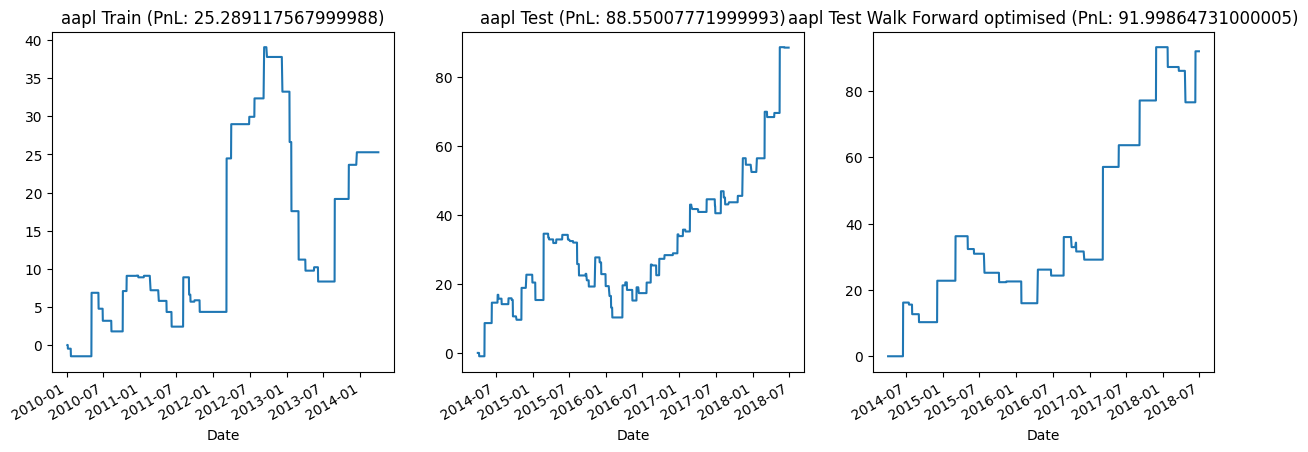

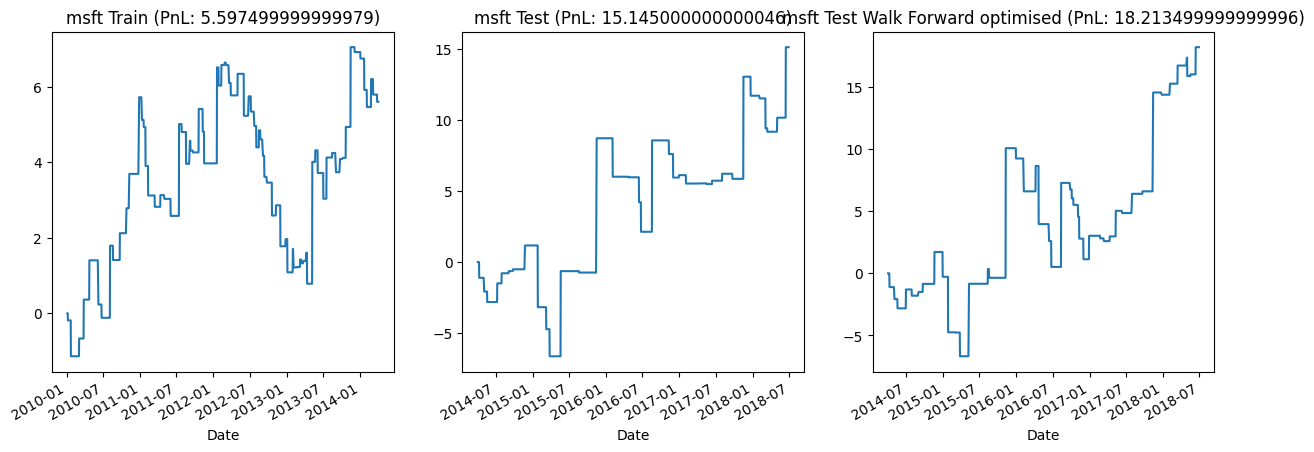

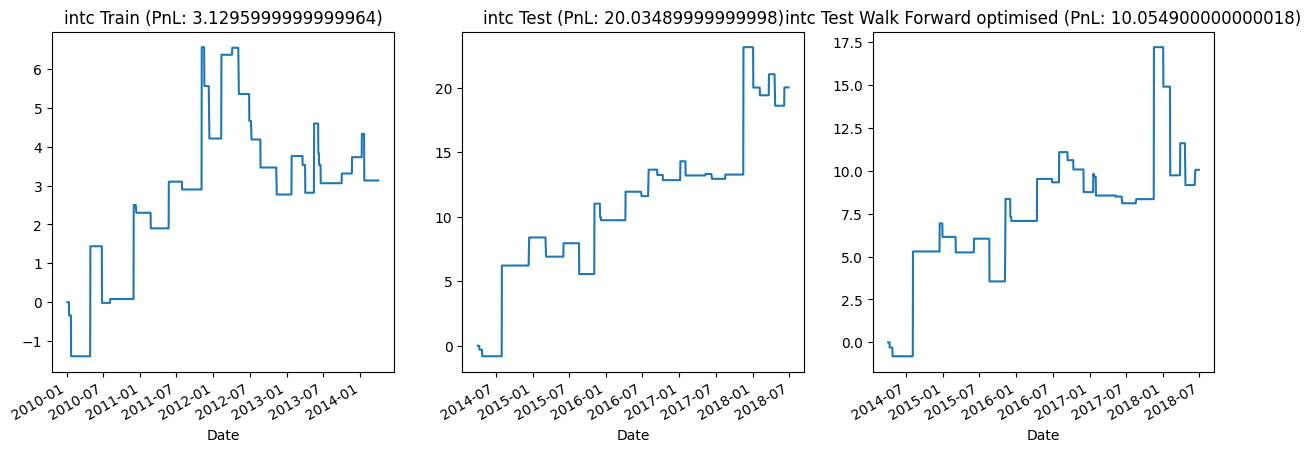

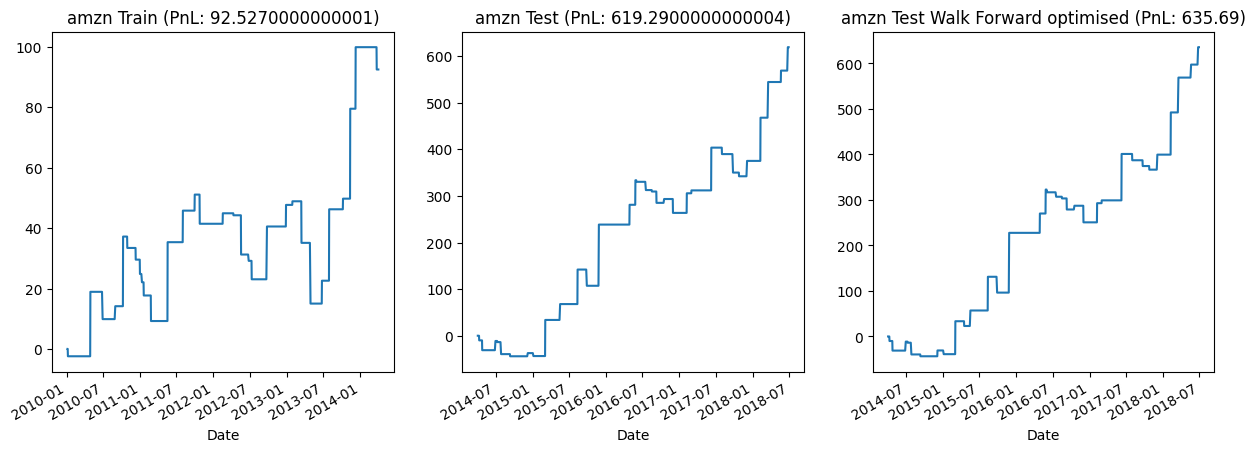

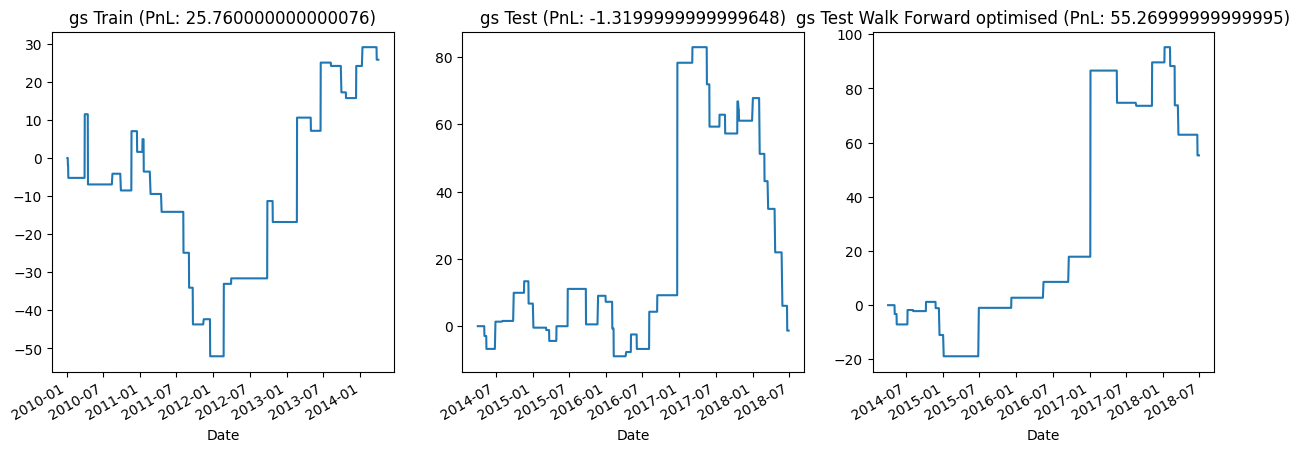

In [183]:
def walk_forward_optimisation(data):
    n = len(data)
    window_size = n // 5
    
    include_genome = []
    optimized_params = []
    i = 0
    while i < 5:
        train, test = train_test_split(data[:i + window_size])
        try:
            optimized_params = genetic_algorithm(train.copy(), population_n=10, include_genome=include_genome)
        except:
            continue
        
        include_genome = [optimized_params[0]]
        i += 1
    
    return optimized_params[0]
        

for ticker_info in tickers:
    fig, axes = plt.subplots(1, 3, figsize = (15, 5))
    ticker, data = ticker_info
    train, test = train_test_split(data)
    optimized_params = genetic_algorithm(train.copy(), population_n=10)
    
    # Train
    short_window, long_window, signal_window = param
    processed_data = calculate_macd(train, short_window, long_window, signal_window)
    signals_data = generate_signals(processed_data)
    pnl = backtest_strategy(signals_data)
    pnl_cumsum = pnl["PnL"].cumsum()
    pnl_cumsum.plot(ax=axes[0])
    axes[0].set_title(f"{ticker} Train (PnL: {pnl_cumsum[-1]})")

    # Test
    param = optimized_params[0]
    short_window, long_window, signal_window = param
    processed_data = calculate_macd(test, short_window, long_window, signal_window)
    signals_data = generate_signals(processed_data)
    pnl = backtest_strategy(signals_data)
    pnl_cumsum = pnl["PnL"].cumsum()
    pnl_cumsum.plot(ax=axes[1])
    axes[1].set_title(f"{ticker} Test (PnL: {pnl_cumsum[-1]})")
    
    # Walk forward
    short_window, long_window, signal_window = walk_forward_optimisation(train.copy())
    processed_data = calculate_macd(test, short_window, long_window, signal_window)
    signals_data = generate_signals(processed_data)
    pnl = backtest_strategy(signals_data)
    pnl_cumsum = pnl["PnL"].cumsum()
    pnl_cumsum.plot(ax=axes[2])
    axes[2].set_title(f"{ticker} Test Walk Forward optimised (PnL: {pnl_cumsum[-1]})")